<a href="https://colab.research.google.com/github/tanaxer01/mov-in-covid/blob/main/index_calcs.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [14]:
from google.colab import drive
drive.mount('/content/drive')

!mkdir ~/.kaggle
!cp /content/drive/MyDrive/kaggle.json ~/.kaggle/kaggle.json
!chmod 600 ~/.kaggle/kaggle.json

!if [ ! -d mov-in-covid ]; then \
  git clone https://github.com/tanaxer01/mov-in-covid; \
  mv mov-in-covid/*.py .; \
  fi

from datetime import datetime, timedelta
from zipfile import ZipFile
import matplotlib.pyplot as plt
import pandas as pd
import numpy  as np
import utils

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
mkdir: cannot create directory ‘/root/.kaggle’: File exists
  0% 0.00/177k [00:00<?, ?B/s]
100% 177k/177k [00:00<00:00, 52.5MB/s]


In [38]:
datasets = {
  # DP1
  "dp1_contagios": "https://raw.githubusercontent.com/MinCiencia/Datos-COVID19/master/output/producto1/Covid-19_std.csv",
  # DP7
  "dp7_pcr": "https://raw.githubusercontent.com/MinCiencia/Datos-COVID19/master/output/producto7/PCR_std.csv",
  # DP20
  "dp20_camas": "https://raw.githubusercontent.com/MinCiencia/Datos-COVID19/master/output/producto20/NumeroVentiladores_std.csv",
  # DP51
  "dp51_difs": "https://raw.githubusercontent.com/MinCiencia/Datos-COVID19/master/output/producto51/ISCI_std.csv",
  # DP82
  "dp82_weeks": "https://raw.githubusercontent.com/MinCiencia/Datos-COVID19/master/output/producto82/ISCI_weeks.csv",
  "dp82_weekends": "https://raw.githubusercontent.com/MinCiencia/Datos-COVID19/master/output/producto82/ISCI_weekends.csv",
  # DP...
}

for name, url in datasets.items():
  utils.get_file(name, url)

[+] downloaded ./datos/dp7_pcr


# DATASET PREP

## DP1
link: [product1](https://github.com/MinCiencia/Datos-COVID19/tree/master/output/producto1)

In [375]:
DataProduct1 = pd.read_csv("./datos/dp1_contagios.csv", parse_dates=["Fecha"])

# Just RM
DataProduct1 = DataProduct1[ DataProduct1["Codigo region"] == 13 ].drop(columns=["Region", "Codigo region"])
DataProduct1 = DataProduct1.set_index("Fecha")
# Week num
DataProduct1["Semana"] = (DataProduct1.index.to_series() - datetime.strptime("2020-01-01", "%Y-%m-%d")).dt.days // 7
# Drop `Desconocido Metropolitana`
DataProduct1 = DataProduct1[ DataProduct1.Comuna != "Desconocido Metropolitana" ]

## cov_all: Cantidad de contagios acumulativa x comuna(columnas) y fecha(index)
cov_all = DataProduct1.pivot_table(values="Casos confirmados", index="Fecha", columns="Comuna")
## cov_new: Cantidad de contagios nuevos x comuna(columnas) y fecha(index)
cov_new = cov_all.subtract( cov_all.shift(periods=1, fill_value=0) )

### Parsing DP1 data 

In [376]:
week2date = lambda x: datetime.strptime("2020-01-01", "%Y-%m-%d") + timedelta(days=x*7)

mondays = cov_new.Santiago[ cov_new.Santiago.index.to_series().dt.weekday == 0 ]

fridays = cov_new.Santiago[ cov_new.Santiago.index.to_series().dt.weekday == 4 ].reset_index()
fridays["Fecha"] = fridays["Fecha"] - timedelta(days=0.5)
fridays = fridays.set_index("Fecha")["Santiago"]

new_index = pd.date_range(start=cov_new.index.min(), end=cov_new.index.max(), freq="3.5D")

## OUT DATA del DP1
# cov_mod: Misma serie de contagios, pero fechas de dia viernes fueron corridas 12 horas hacia atras.
cov_mod = pd.Series(pd.concat([mondays, fridays]), index=new_index).interpolate().rename("casos")

In [377]:
mondays = cov_all.Santiago[ cov_all.Santiago.index.to_series().dt.weekday == 0 ]

fridays = cov_all.Santiago[ cov_all.Santiago.index.to_series().dt.weekday == 4 ].reset_index()
fridays["Fecha"] = fridays["Fecha"] - timedelta(days=0.5)
fridays = fridays.set_index("Fecha")["Santiago"]

new_index = pd.date_range(start=cov_all.index.min(), end=cov_all.index.max(), freq="3.5D")

## OUT DATA del DP1
# cov_all: Misma serie de contagios, pero fechas de dia viernes fueron corridas 12 horas hacia atras.
cov_total = pd.Series(pd.concat([mondays, fridays]), index=new_index).interpolate().rename("casos_totales") 

### Seasonalinty in the dataset
A primera vista, se ve que dentro de los 3 años hay un aumento de contagios entre mayo y julio. Pero hay algunos aumentos anomalos, a principios de 2022 hay un amuendo drastico de contagios el que creemos se debe a la variante OMICRON.

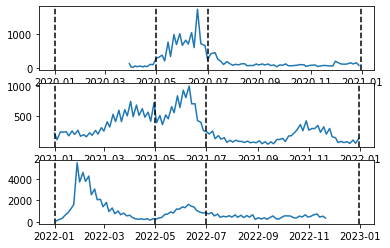

In [378]:
plt.subplot(3,1,1)
plt.plot( cov_new["Santiago"].loc["2020-01-01":"2020-12-31"] )

for i in ["2020-01-01","2020-12-31","2020-05-01","2020-07-01"]:
  plt.axvline(x=datetime.strptime(i,"%Y-%m-%d"), color='black', linestyle='--')

plt.subplot(3,1,2)
plt.plot( cov_new["Santiago"].loc["2021-01-01":"2021-12-31"] )

for i in ["2021-01-01","2021-12-31", "2021-05-01", "2021-07-01"]:
  plt.axvline(x=datetime.strptime(i,"%Y-%m-%d"), color='black', linestyle='--')

plt.subplot(3,1,3)
plt.plot( cov_new["Santiago"].loc["2022-01-01":"2022-12-31"] )

for i in ["2022-01-01","2022-12-31", "2022-05-01","2022-07-01"]:
  plt.axvline(x=datetime.strptime(i,"%Y-%m-%d"), color='black', linestyle='--')
  
plt.show()

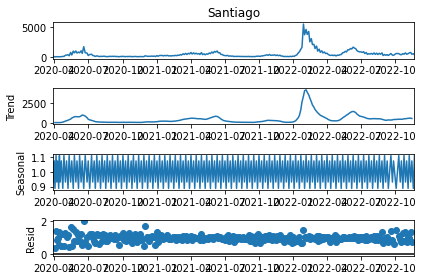

In [379]:
from statsmodels.tsa.seasonal import seasonal_decompose

decompose = seasonal_decompose(cov_new["Santiago"], period=4, model="multiplicative").plot()

## DP7

In [380]:
DataProduct7 = pd.read_csv("./datos/dp7_pcr.csv", parse_dates=["fecha"])
# Just RM
DataProduct7 = DataProduct7[ DataProduct7['Codigo region'] == 13 ]

a = DataProduct7["fecha"]

pcr_cants = DataProduct7[["numero", "fecha"]]

pcr_cants = pcr_cants.set_index("fecha")["numero"]
pcr_cants = pcr_cants.rename("pcr").asfreq("84H").interpolate()

## DP 20

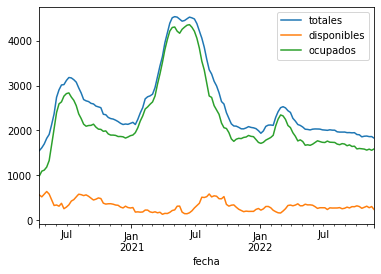

In [381]:
DataProduct20 = pd.read_csv("./datos/dp20_camas.csv", parse_dates=["fecha"])

a = DataProduct20["fecha"]
DataProduct20 = DataProduct20.set_index("fecha")

camas_criticas = pd.DataFrame({ 
    "totales": DataProduct20[ DataProduct20.Ventiladores == "total" ]["numero"],
    "disponibles": DataProduct20[ DataProduct20.Ventiladores == "disponibles" ]["numero"],
    "ocupados": DataProduct20[ DataProduct20.Ventiladores == "ocupados" ]["numero"]
}).asfreq("84H").interpolate()


camas_criticas.plot()

## DP51
link: [product51](https://github.com/MinCiencia/Datos-COVID19/tree/master/output/producto51)


In [382]:
df_difs = pd.read_csv("./datos/dp51_difs.csv", parse_dates=["Fecha"])

# Just RM
df_difs = df_difs[ df_difs['Codigo region'] == 13 ].drop(columns=['Region', 'Codigo region'])

# Calc prom of Dif salida y Dif entrada.
def parse_diff(x):
  mean = sum([ int(i)  for i in x[1:-2].replace('%','').split(",") ])/2
  
  return (100 + mean)/100

df_difs['Salida'] = df_difs['Dif salida'].map(parse_diff)
df_difs['Entrada'] = df_difs['Dif entrada'].map(parse_diff)

df_salidas  = pd.DataFrame({ i:df_difs[ df_difs["Comuna"] == i ].groupby("Fecha")["Salida"].mean() for i in set(df_difs["Comuna"]) }).asfreq("84H").interpolate()
df_entradas = pd.DataFrame({ i:df_difs[ df_difs["Comuna"] == i ].groupby("Fecha")["Entrada"].mean() for i in set(df_difs["Comuna"]) }).asfreq("84H").interpolate()

df_entradas.head(2)

,Lampa,Calera de Tango,Ñuñoa,Providencia,Independencia,Lo Barnechea,Puente Alto,La Cisterna,Lo Prado,Colina,...,La Pintana,Pirque,María Pinto,Macul,Renca,El Monte,Vitacura,Estación Central,Maipú,Las Condes
Fecha,,,,,,,,,,,,,,,,,,,,,
2020-03-02 00:00:00,1.06650,1.265,1.016803,1.029510,1.143462,1.045909,1.163662,1.114130,1.355000,1.296944,...,1.261875,0.995,1.67,1.171364,1.184318,1.085,1.003846,1.188488,1.189419,0.998537
2020-03-05 12:00:00,1.07125,1.265,1.019180,1.028137,1.131538,1.038864,1.159190,1.107391,1.331774,1.292222,...,1.246563,0.995,1.67,1.169091,1.190909,1.085,1.015000,1.185930,1.183256,1.021463


In [383]:
df_salidas.head()


,Lampa,Calera de Tango,Ñuñoa,Providencia,Independencia,Lo Barnechea,Puente Alto,La Cisterna,Lo Prado,Colina,...,La Pintana,Pirque,María Pinto,Macul,Renca,El Monte,Vitacura,Estación Central,Maipú,Las Condes
Fecha,,,,,,,,,,,,,,,,,,,,,
2020-03-02 00:00:00,1.0760,1.265000,1.021557,1.026765,1.119615,1.031818,1.154718,1.100652,1.308548,1.287500,...,1.237708,0.995,1.670,1.176212,1.1975,1.085,1.026154,1.202209,1.177093,1.044390
2020-03-05 12:00:00,1.0760,1.265000,1.021557,1.026765,1.119615,1.031818,1.154718,1.100652,1.308548,1.287500,...,1.234479,0.995,1.670,1.171515,1.1975,1.085,1.026154,1.192791,1.177093,1.044390
2020-03-09 00:00:00,1.0760,1.265000,1.021557,1.026765,1.119615,1.031818,1.154718,1.100652,1.308548,1.287500,...,1.231250,0.995,1.670,1.166818,1.1975,1.085,1.026154,1.183372,1.177093,1.044390
2020-03-12 12:00:00,1.0035,1.231667,0.915820,0.887549,1.119615,0.897727,1.134648,1.094130,1.308548,1.218056,...,1.228125,0.845,1.645,1.112273,1.1975,1.035,0.878077,1.172907,1.149186,0.907805
2020-03-16 00:00:00,0.9310,1.198333,0.810082,0.748333,1.119615,0.763636,1.114577,1.087609,1.308548,1.148611,...,1.225000,0.695,1.620,1.057727,1.1975,0.985,0.730000,1.162442,1.121279,0.771220


## DP82
link: [product82](https://github.com/MinCiencia/Datos-COVID19/tree/master/output/producto82)

In [384]:
df_weeks = pd.read_csv('./datos/dp82_weeks.csv', parse_dates=["fecha_inicio"])
#df_weekends = pd.read_csv('./datos/dp82_weekends.csv', parse_dates=["fecha_inicio"])

week2day = lambda x: datetime.strptime("2020-01-01", "%Y-%m-%d") + timedelta(days=x*7)

# Fecha to Datetime && sort by Fecha
#df_weeks['fecha_inicio'] = pd.to_datetime(df_weeks['fecha_inicio'])
#df_weeks = df_weeks.sort_values(by=['fecha_inicio'])

# Just RM
df_weeks = df_weeks[ df_weeks['region'] == 13 ].drop(columns=['region'])

# Just dates on DP51
# df_weeks = df_weeks[ df_weeks["fecha_inicio"].isin(df_difs["Fecha"]) ]

# [!] Fill pasos 
df_weeks["paso"] = df_weeks["paso"].fillna(method="ffill")

# paso_a_paso: 
paso_a_paso = df_weeks.pivot_table(values='paso', index='semana', columns='nom_comuna')

# paso_out: Dataframe del paso a paso con las muestras cada 3.5 días tal como el dataset de contagios
paso_out = paso_a_paso.reset_index()
paso_out["semana"] = paso_out["semana"].apply(week2day) - timedelta(days=2)
paso_out = paso_out.set_index("semana").asfreq("84H").interpolate().rename(columns={ i:"pasos-"+i.lower() for i in paso_out.columns})

# var_salidas:
var_salidas = df_weeks.pivot_table(values="var_salidas", index="semana", columns="nom_comuna")

# var_out: Dataframe del indice de movilidad con las muestras cada 3.5 días tal como el dataset de contagios
var_out = var_salidas.reset_index()
var_out["semana"] = var_out["semana"].apply(week2day) - timedelta(days=2)
var_out = var_out.set_index("semana").asfreq("84H").interpolate().rename(columns={ i:"var-"+i.lower() for i in var_out.columns})

In [385]:
with ZipFile("world-covid-varients.zip", "r") as archivo:
  variantes = pd.read_csv(archivo.open("covid-variants.csv", "r"), parse_dates=["date"])

# variantes[ (variantes.location == "Chile") & (variantes.variant == "B.1.1.529") ]
variantes[variantes['variant'] == 'B.1.1.519']

,location,date,variant,num_sequences,perc_sequences,num_sequences_total
6,Angola,2020-12-21,B.1.1.519,NaN,NaN,93
29,Angola,2021-01-25,B.1.1.519,NaN,NaN,52
52,Angola,2021-02-08,B.1.1.519,NaN,NaN,42
75,Angola,2021-02-22,B.1.1.519,NaN,NaN,39
98,Angola,2021-03-08,B.1.1.519,NaN,NaN,113
...,...,...,...,...,...,...
37266,Zimbabwe,2020-06-08,B.1.1.519,NaN,NaN,41
37289,Zimbabwe,2021-01-04,B.1.1.519,NaN,NaN,160
37312,Zimbabwe,2021-01-11,B.1.1.519,NaN,NaN,114
37335,Zimbabwe,2021-01-25,B.1.1.519,NaN,NaN,57


## `Dif salida` VS `var_salidas`
En general siguen las mismas tendencias, pero tienen una diferencia de 0.2 que no estoy seguro pq ocurre.
Lo unico raro es la diferencia al final, (el peak hacia abajo es por un error de mediciones en uno de los datasets.) pero al final, el dataset `var` tiene un amuento raro que no se ve en la otra curva.

In [386]:
#dif  = df_salidas["Santiago"]
#var  = df_weeks[ df_weeks["nom_comuna"] == "SANTIAGO" ].set_index("fecha_inicio")
#
#var_salidas = var["var_salidas"]
#paso = var["paso"]
#
#plt.figure()
#
#plt.plot(paso / 8 + 0.5)
#plt.plot(var_salidas)
#plt.plot(dif - 0.2)
#
#plt.legend(["var", "dif"])
#plt.show()
#
#f"shift promedio entre var y dif: {(dif - var_salidas).mean()}"

# Date checking within the datasets

['pcr' 'var-alhué' 'var-maría pinto' 'var-el monte']


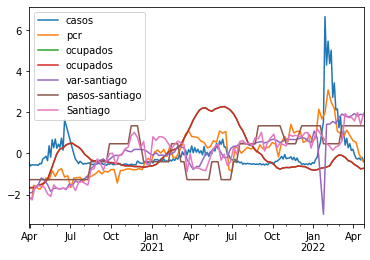

In [400]:
# Data prep
camas_ocupadas = camas_criticas["ocupados"].reset_index()
camas_ocupadas["fecha"] -= timedelta(days=1)
camas_ocupadas = camas_ocupadas.set_index("fecha").reindex(cov_mod.index, method="bfill")

pcrs_realized = pcr_cants.reset_index()
pcrs_realized["fecha"] += timedelta(days=0.5)
pcrs_realized = pcrs_realized.set_index("fecha").reindex(cov_mod.index, fill_value=0)


data = pd.concat([ cov_mod, pcrs_realized, camas_ocupadas, var_out, paso_out, camas_ocupadas, df_entradas["Santiago"] ], axis=1).dropna()
data = (data-data.mean())/data.std()




data[["casos", "pcr", "ocupados", "var-santiago", "pasos-santiago", "Santiago"]].plot()

test = data.corr()["casos"].sort_values(ascending=False).iloc[1:5].index.values
print(test)

# Medición de eficiencia

## Base model

In [394]:
# from sklearn.decomposition import PCA

# pca = PCA(n_components=5)
# principalComponents = pca.fit_transform(X)
# principalDF = pd.DataFrame(data=principalComponents, columns=['prin '+str(i) for i in range(5)])

# principalDF.head(5)

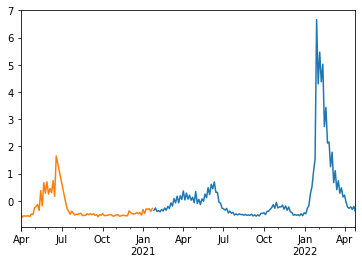

In [402]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

#X = data.drop(columns=["casos"])
#y = data["casos"] 

cut = round(data.shape[0]*0.7)
#X_train, X_test = data.drop(columns=["casos"]).iloc[:round(data.shape[0]*0.7)], data.drop(columns=["casos"]).iloc[-1*round(data.shape[0]*0.3):]
#y_train, y_test = data["casos"].iloc[:round(data.shape[0]*0.7)], data["casos"].iloc[-1*round(data.shape[0]*0.3):]
#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

X = data[[ "pcr", "ocupados", "var-santiago", "pasos-santiago", "Santiago"]]
# X = StandardScaler().fit_transform(X)

y = data["casos"] 

#X_train, X_test = X.iloc[:round(data.shape[0]*0.7)], X.iloc[-1*round(data.shape[0]*0.3):]
#y_train, y_test = y.iloc[:round(data.shape[0]*0.7)], y.iloc[-1*round(data.shape[0]*0.3):]

#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.60, shuffle=False)

fig, ax = plt.subplots()
y_test.plot(ax=ax)
y_train.plot(ax=ax)


Mean squared error: 885431.99
Coefficient of determination: -0.10
-18.50 accuracy with a standard deviation of 23.53 AKA it sucks


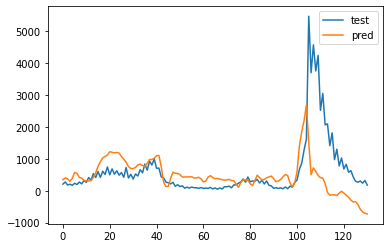

In [398]:
from sklearn import linear_model
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_squared_error, r2_score

from sklearn.linear_model import Perceptron

# clf = Perceptron(tol=1e-3, random_state=0)
# clf.fit(X_train,y_train)

# y_pred = clf.predict(X_test)

reg = linear_model.LinearRegression()
reg.fit(X_train,y_train)

y_pred = reg.predict(X_test)

# The mean squared error
print("Mean squared error: %.2f" % mean_squared_error(y_test, y_pred))
# The coefficient of determination: 1 is perfect prediction
print("Coefficient of determination: %.2f" % r2_score(y_test, y_pred))

scores = cross_val_score(reg, X_test, y_test, cv=10)
print("%0.2f accuracy with a standard deviation of %0.2f AKA it sucks" % (scores.mean(), scores.std()))

plt.figure()

plt.plot(y_test.values)
plt.plot(y_pred)
plt.legend(['test','pred'])

plt.show()

In [ ]:
# (0.7 v 0.3) 4.19, -0.63 & -243.09 accuracy with a standard deviation of 461.78
# (0.6 v 0.4) 2.91, -0.39 & -128.24 accuracy with a standard deviation of 198.83
# (0.5 v 0.5) 2.30, -0.36 & -62.17 accuracy with a standard deviation of 104.16
# >>>> (0.4 v 0.6) 1.58, -0.10 & -18.58 accuracy with a standard deviation of 23.82
# (0.3 v 0.7) 1.83, -0.43 & -58.57 accuracy with a standard deviation of 86.91
# (0.2 v 0.8) 2.31, -1.00 & -78.19 accuracy with a standard deviation of 132.44
# (0.1 v 0.9) 1.34, -0.24 & -36.18 accuracy with a standard deviation of 43.3

In [ ]:
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA

#steps = [('pca', PCA(n_components=10)), ('m', linear_model.LogisticRegression())]
#model = Pipeline(steps=steps)




## First Aproach

In [253]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

def sarimax(ts, exo, all_params):
  results = []
  for param in all_params:
    try:
      mod = SARIMAX(ts, exog=exo, order=param[0], seasonal_order=param[1], \
                    enforce_stationarity = False, enforce_invertibility = False)
      #res = mod.fit(maxiter=200, method='powell')
      res = mod.fit()

      results.append((res, res.aic,param))
      print('Tried out SARIMAX{}x{} - AIC:{}'.format(param[0], param[1], round(res.aic,2)))

    except Exception as e:
      print(e)
      continue

  return results

In [254]:
week2day = lambda x: datetime.strptime("2020-01-01", "%Y-%m-%d") + timedelta(days=x*7)

endo_train, endo_test = data["casos"].iloc[:round(data.shape[0]*0.7)], data["casos"][round(data.shape[0]*0.7):]
exo_train,   exo_test = data.drop(columns=["casos"]).iloc[:round(data.shape[0]*0.7)], data["casos"][round(data.shape[0]*0.7):]

endo_train.index.freq = "84H"
exo_train.index.freq = "84H"

endo_test.index.freq = "84H"
exo_test.index.freq = "84H"

In [250]:
data.shape

(217, 107)

In [267]:
mod = SARIMAX(endo_train,exo=exo_train, order=(0,1,0), seasonal_order=(0, 1, 0, 7))
res = mod.fit(method="powell")
print("SARIMAX{}x{} - AIC:{}".format((0,1,0), (0,1,0,7),round(res.aic,2)))

Optimization terminated successfully.
         Current function value: 0.490458
         Iterations: 2
         Function evaluations: 69
SARIMAX(0, 1, 0)x(0, 1, 0, 7) - AIC:151.1


In [256]:
import itertools

# set parameter range
p,d,q = range(0,3),[1],range(0,3)
P,D,Q,s = range(0,3),[1],range(0,3),[7]
# list of all parameter combos
pdq = list(itertools.product(p, d, q))
seasonal_pdq = list(itertools.product(P, D, Q, s))
all_param = list(itertools.product(pdq,seasonal_pdq))

all_res = sarimax(endo_train,exo_train,all_param)

/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


Tried out SARIMAX(0, 1, 0)x(0, 1, 0, 7) - AIC:329.08


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


Tried out SARIMAX(0, 1, 0)x(0, 1, 1, 7) - AIC:187.43


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


Tried out SARIMAX(0, 1, 0)x(0, 1, 2, 7) - AIC:124.69


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


Tried out SARIMAX(0, 1, 0)x(1, 1, 0, 7) - AIC:211.63


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


Tried out SARIMAX(0, 1, 0)x(1, 1, 1, 7) - AIC:175.48


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


Tried out SARIMAX(0, 1, 0)x(1, 1, 2, 7) - AIC:142.55


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


Tried out SARIMAX(0, 1, 0)x(2, 1, 0, 7) - AIC:114.86


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


Tried out SARIMAX(0, 1, 0)x(2, 1, 1, 7) - AIC:115.7


KeyboardInterrupt: ignored

Ljung-box p-values:
[5.01966223e-018 2.59761578e-033 1.83783353e-043 1.43353295e-052
 8.30657339e-063 3.50034550e-072 1.96697058e-088 2.47325188e-099
 7.23842661e-109 7.19339867e-116 9.97506768e-121 3.31635415e-124
 2.05270617e-127 1.00611774e-130]


<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                     
=========================================================================================
Dep. Variable:                             casos   No. Observations:                  152
Model:             SARIMAX(0, 1, 0)x(0, 1, 0, 7)   Log Likelihood                 -74.550
Date:                           Fri, 25 Nov 2022   AIC                            151.099
Time:                                   15:59:57   BIC                            154.069
Sample:                               03-30-2020   HQIC                           152.306
                                    - 09-09-2021                                         
Covariance Type:                             opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2         0.1649      0.010     16.011      0.000       0.145       0.185
===================================================================================
Ljung-Box (L1) (Q):                  74.87   Jarque-Bera (JB):               158.09
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               0.47   Skew:                            -0.17
Prob(H) (two-sided):                  0.01   Kurtosis:                         8.12
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

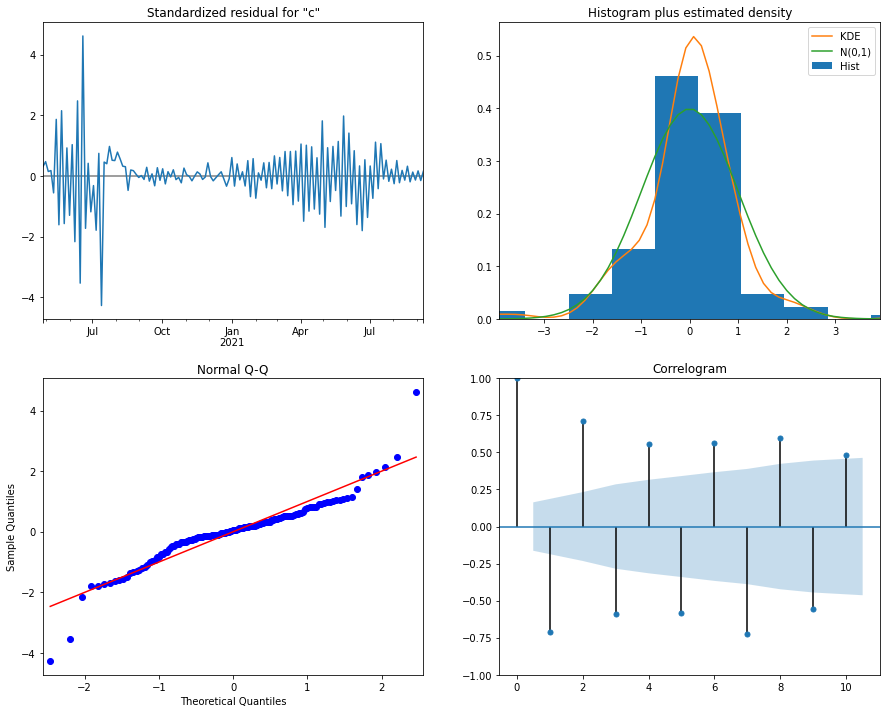

In [268]:
res.plot_diagnostics(figsize=(15, 12))
print("Ljung-box p-values:\n" + str(res.test_serial_correlation(method='ljungbox')[0][1]))
res.summary()

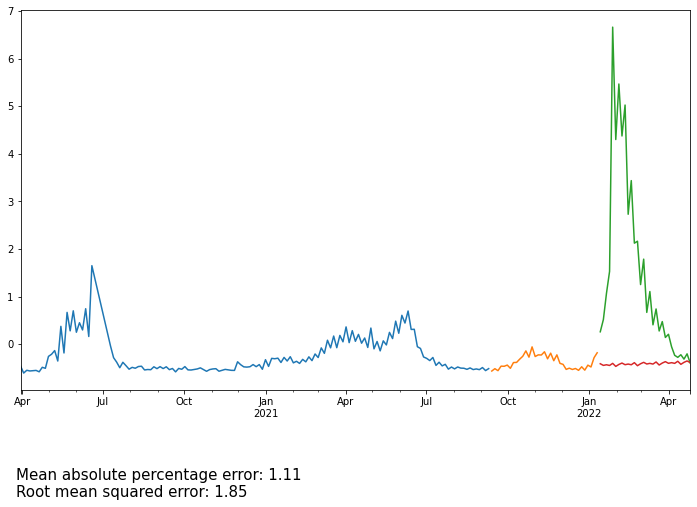

((65,), (30,))

In [335]:
from sklearn.metrics import mean_squared_error as MSE, r2_score, mean_absolute_percentage_error as MAPE
from math import sqrt

train_start = endo_train.head(1).index.to_series().iloc[0]
train_end = endo_train.tail(1).index.to_series().iloc[0]

test_start = endo_test.head(1).index.to_series().iloc[0]
test_end = endo_test.tail(1).index.to_series().iloc[0]

demo_start = test_start + timedelta(days=120)

pred_test = res.get_prediction(start=test_start,end=test_end ,exog=exo_test)
err = 'Mean absolute percentage error: %.2f'% MAPE(endo_test, pred_test.predicted_mean) + \
 '\nRoot mean squared error: %.2f'% sqrt(MSE(endo_test, pred_test.predicted_mean))

#pred = res.get_prediction(start=test_start,end=test_end,exog=exo_test)
pred = res.get_prediction(start = demo_start, end = test_end ,exog=exo_test)
pred_ci = pred.conf_int()

fig, ax = plt.subplots(figsize=(12,7))

endo_train.plot(ax=ax)
endo_test.loc[:demo_start].plot(ax=ax)
endo_test.loc[demo_start:].plot(ax=ax)

pred.predicted_mean.plot(ax=ax)
ci = pred_ci

#ax.fill_between(ci.index, ci.iloc[:,0], ci.iloc[:,1], color='r', alpha=0.1)
plt.figtext(0.12, -0.06, err, ha="left",fontsize=15,va='center')
plt.show()


endo_test.shape, pred.predicted_mean.shape #, MAPE(endo_test, pred_test.predicted_mean)

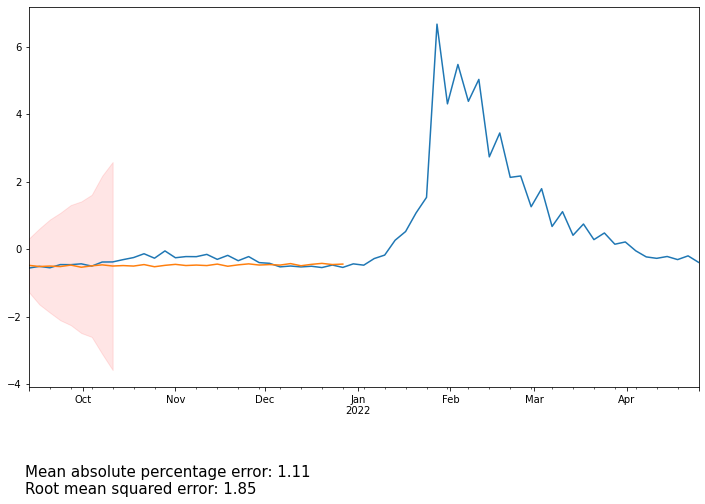

In [275]:
fig, ax = plt.subplots(figsize=(12,7))

#endo_train.plot(ax=ax)
endo_test.loc[test_start:test_end].plot(ax=ax)

pred.predicted_mean.plot(ax=ax)

ax.fill_between(ci.index, ci.iloc[:,0], ci.iloc[:,1], color='r', alpha=0.1)
plt.figtext(0.12, -0.06, err, ha="left",fontsize=15,va='center')
plt.show()

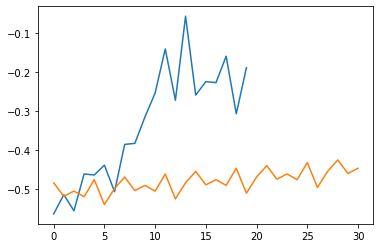

In [274]:
#fcst = res.forecast(steps=10, exog =exo_test)
pred = res.get_prediction(start=test_start,end=test_start + timedelta(days=105),exog=exo_test)

plt.figure()
plt.plot(list(endo_test.iloc[:20]))
plt.plot(list(pred.predicted_mean))

plt.show()

## Second 

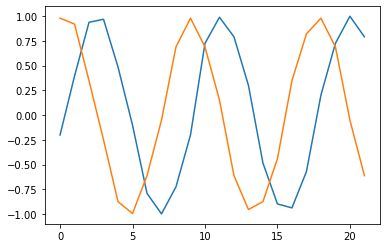

In [ ]:
date = cov_mod.index.to_series()
days = date.dt.day

all['cov_sin'] = np.sin( (days * 2 * np.pi) / days.max())
all['cov_cos'] = np.cos( (days * 2 * np.pi) / days.max())


plt.plot(np.array(all['cov_sin'])[:22])
plt.plot(np.array(all['cov_cos'])[:22])

In [ ]:
all.describe()

,casos,var-ALHUÉ,var-BUIN,var-CALERA DE TANGO,var-CERRILLOS,var-CERRO NAVIA,var-COLINA,var-CONCHALÍ,var-CURACAVÍ,var-EL BOSQUE,...,pasos-SAN JOSÉ DE MAIPO,pasos-SAN MIGUEL,pasos-SAN RAMÓN,pasos-SANTIAGO,pasos-TALAGANTE,pasos-TILTIL,pasos-VITACURA,pasos-ÑUÑOA,cov_sin,cov_cos
count,239.000000,239.000000,239.000000,239.000000,239.000000,239.000000,239.000000,239.000000,239.000000,239.000000,...,239.000000,239.000000,239.000000,239.000000,239.000000,239.000000,239.000000,239.000000,2.390000e+02,239.000000
mean,512.880753,0.742394,0.902979,0.885505,0.859130,0.867376,0.809631,0.853422,0.918507,0.904388,...,2.548117,2.405858,2.439331,2.600418,2.560669,2.673640,2.705021,2.738494,1.078286e-02,-0.011785
std,735.910974,0.381725,0.150979,0.160989,0.117828,0.114131,0.156344,0.120413,0.129322,0.125757,...,1.352824,1.276002,1.263989,1.178127,1.330982,1.314782,1.194928,1.129774,7.143935e-01,0.702558
min,17.000000,0.234691,0.534907,0.498236,0.487216,0.461811,0.456192,0.503848,0.646424,0.500244,...,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,-9.987165e-01,-0.994869
25%,107.500000,0.470512,0.810116,0.786954,0.797672,0.792131,0.721592,0.781212,0.838801,0.842242,...,1.000000,1.000000,1.000000,1.000000,1.500000,2.000000,2.000000,2.000000,-7.247928e-01,-0.685432
50%,263.000000,0.655662,0.918148,0.908353,0.853059,0.849781,0.823007,0.833559,0.923274,0.907781,...,3.000000,2.000000,2.500000,3.000000,3.000000,3.000000,3.000000,3.000000,-2.449294e-16,-0.050649
75%,660.000000,0.853619,0.968901,0.941737,0.911034,0.908532,0.886418,0.900232,0.960755,0.950790,...,4.000000,4.000000,4.000000,4.000000,4.000000,4.000000,4.000000,4.000000,7.247928e-01,0.688967
max,5474.000000,1.588193,1.172378,1.172989,1.082171,1.096292,1.096655,1.091611,1.152432,1.136374,...,4.000000,4.000000,4.000000,4.000000,4.000000,4.000000,4.000000,4.000000,9.987165e-01,1.000000


In [ ]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler(feature_range=(0, 1))
scaler_casos = MinMaxScaler(feature_range=(0, 1)).fit(all[["casos"]])

all_normalized = pd.DataFrame(scaler.fit_transform(all), columns = all.columns.values, index = all.index)
all_normalized

,casos,var-ALHUÉ,var-BUIN,var-CALERA DE TANGO,var-CERRILLOS,var-CERRO NAVIA,var-COLINA,var-CONCHALÍ,var-CURACAVÍ,var-EL BOSQUE,...,pasos-SAN JOSÉ DE MAIPO,pasos-SAN MIGUEL,pasos-SAN RAMÓN,pasos-SANTIAGO,pasos-TALAGANTE,pasos-TILTIL,pasos-VITACURA,pasos-ÑUÑOA,cov_sin,cov_cos
2020-03-30 00:00:00,0.020158,0.106882,0.214546,0.159417,0.388687,0.408208,0.119932,0.329012,0.144427,0.364724,...,0.0,0.0,0.0,0.0,0.0,0.0,0.250,0.25,0.399221,0.989739
2020-04-02 12:00:00,0.000000,0.060422,0.208714,0.168379,0.377382,0.429445,0.136709,0.346219,0.145572,0.403810,...,0.0,0.0,0.0,0.0,0.0,0.0,0.250,0.25,0.697431,0.959375
2020-04-06 00:00:00,0.008063,0.013961,0.202881,0.177341,0.366076,0.450681,0.153486,0.363425,0.146717,0.442895,...,0.0,0.0,0.0,0.0,0.0,0.0,0.250,0.25,0.969479,0.672813
2020-04-09 12:00:00,0.006047,0.011329,0.208049,0.202241,0.397024,0.453799,0.170045,0.372964,0.139266,0.414455,...,0.0,0.0,0.0,0.0,0.0,0.0,0.125,0.25,0.984661,0.373065
2020-04-13 00:00:00,0.006780,0.008696,0.213216,0.227141,0.427972,0.456917,0.186605,0.382503,0.131815,0.386015,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000,0.25,0.742963,0.060416
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-06-27 00:00:00,0.153198,0.807642,0.973433,0.951874,0.959566,0.950897,0.897001,0.940946,0.932659,0.955052,...,1.0,1.0,1.0,1.0,1.0,1.0,1.000,1.00,0.137138,0.844083
2022-06-30 12:00:00,0.152465,0.854259,0.922493,0.914214,0.929643,0.930178,0.869008,0.927455,0.909634,0.919999,...,1.0,1.0,1.0,1.0,1.0,1.0,1.000,1.00,0.399221,0.989739
2022-07-04 00:00:00,0.136522,0.900876,0.871553,0.876553,0.899720,0.909458,0.841014,0.913964,0.886608,0.884945,...,1.0,1.0,1.0,1.0,1.0,1.0,1.000,1.00,0.862862,0.844083
2022-07-07 12:00:00,0.157229,0.889514,0.850023,0.857211,0.888655,0.892388,0.829766,0.919591,0.934874,0.876774,...,1.0,1.0,1.0,1.0,1.0,1.0,1.000,1.00,0.994869,0.574623


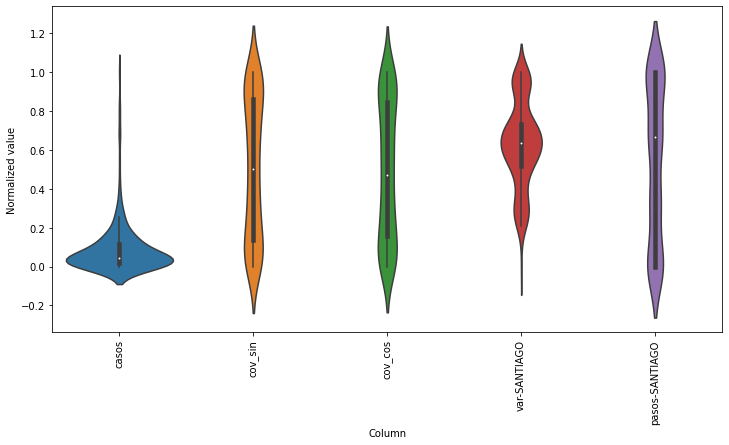

In [ ]:
import seaborn as sns

melt_plot = all_normalized[["casos", "cov_sin", "cov_cos", "var-SANTIAGO", "pasos-SANTIAGO"]].melt(var_name='Column', value_name='Normalized value')
plt.figure(figsize=(12, 6))
ax = sns.violinplot(x='Column', y='Normalized value', data=melt_plot)
_ = ax.set_xticklabels(all_normalized[["casos", "cov_sin", "cov_cos", "var-SANTIAGO", "pasos-SANTIAGO"]].keys(), rotation=90)

In [ ]:
train_end = all.index.to_series().iloc[ round(all.index.to_series().shape[0] * 0.7) ]
test_end = all.index.max()
demo_end = all.index.to_series().iloc[ round(all.index.to_series().shape[0] * 0.9) ]

test_df = all_normalized[train_end:]
train_val = all_normalized[:train_end]

n = len(train_val)

train_df = train_val[:int(n*0.8)]
val_df = train_val[int(n*0.8):]

column_indices = {name: i for i, name in enumerate(all.columns)}
num_features = all.shape[1]
train_df

,casos,var-ALHUÉ,var-BUIN,var-CALERA DE TANGO,var-CERRILLOS,var-CERRO NAVIA,var-COLINA,var-CONCHALÍ,var-CURACAVÍ,var-EL BOSQUE,...,pasos-SAN JOSÉ DE MAIPO,pasos-SAN MIGUEL,pasos-SAN RAMÓN,pasos-SANTIAGO,pasos-TALAGANTE,pasos-TILTIL,pasos-VITACURA,pasos-ÑUÑOA,cov_sin,cov_cos
2020-03-30 00:00:00,0.020158,0.106882,0.214546,0.159417,0.388687,0.408208,0.119932,0.329012,0.144427,0.364724,...,0.000,0.000,0.000,0.000000,0.000,0.000,0.250,0.250,0.399221,0.989739
2020-04-02 12:00:00,0.000000,0.060422,0.208714,0.168379,0.377382,0.429445,0.136709,0.346219,0.145572,0.403810,...,0.000,0.000,0.000,0.000000,0.000,0.000,0.250,0.250,0.697431,0.959375
2020-04-06 00:00:00,0.008063,0.013961,0.202881,0.177341,0.366076,0.450681,0.153486,0.363425,0.146717,0.442895,...,0.000,0.000,0.000,0.000000,0.000,0.000,0.250,0.250,0.969479,0.672813
2020-04-09 12:00:00,0.006047,0.011329,0.208049,0.202241,0.397024,0.453799,0.170045,0.372964,0.139266,0.414455,...,0.000,0.000,0.000,0.000000,0.000,0.000,0.125,0.250,0.984661,0.373065
2020-04-13 00:00:00,0.006780,0.008696,0.213216,0.227141,0.427972,0.456917,0.186605,0.382503,0.131815,0.386015,...,0.000,0.000,0.000,0.000000,0.000,0.000,0.000,0.250,0.742963,0.060416
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-06-24 12:00:00,0.071101,0.299837,0.531079,0.540572,0.574668,0.534486,0.463676,0.464904,0.498151,0.629572,...,0.250,0.375,0.375,0.000000,0.375,0.250,0.375,0.375,0.005131,0.574623
2021-06-28 00:00:00,0.046546,0.399035,0.577734,0.608341,0.622936,0.580989,0.527086,0.504046,0.573271,0.683922,...,0.250,0.500,0.500,0.000000,0.500,0.250,0.500,0.500,0.213999,0.910151
2021-07-01 12:00:00,0.042514,0.421265,0.583134,0.611994,0.618870,0.587815,0.553564,0.522102,0.570158,0.675499,...,0.375,0.500,0.500,0.166667,0.500,0.375,0.500,0.500,0.600779,0.989739
2021-07-05 00:00:00,0.036100,0.443494,0.588533,0.615647,0.614804,0.594641,0.580042,0.540158,0.567045,0.667076,...,0.500,0.500,0.500,0.333333,0.500,0.500,0.500,0.500,0.924867,0.763876


In [ ]:
def split_sequence(df, fea_width=28, label_width=1, shift=1, label_col_indices=[0]):
  arr = df.to_numpy()
 
  # Work out the label column indices.

  window_size = fea_width + shift + label_width - 1
  fea_slice = slice(0, fea_width)
  fea_indices = np.arange(window_size)[fea_slice]
  
  label_slice = slice(window_size - label_width, None)
  label_indices = np.arange(window_size)[label_slice]
  
  
  print("\n window_size: {} \n fea_indices: {} \n label_indices: {}"
        .format(window_size,fea_indices,label_indices))

  def split_window(window):
    features = window[fea_slice]
    labels = window[label_slice]
#         print(label_col)
#         print([label_col_indices[name] for name in label_col])
    if label_col_indices is not None:
      labels = np.stack(
        [labels[:, label_col_indices[idx]] 
          for idx in label_col_indices],
          axis=-1)


    labels = labels.flatten()
        
    return features, labels
  
  n = len(arr)

  X,y = list(),list()
  for i in range(0, n, shift):
    window = arr[i:i+window_size]
    if (len(window) != window_size): break


  # Find the end of this pattern:
  features,labels = split_window(window)
  X.append(features)
  y.append(labels)


  return X,y

In [ ]:
fea_width, label_width, shift, label_col_indices = 28, 1, 1, [0]

X_all,y_all = split_sequence(all_normalized)

X_train,y_train = split_sequence(train_df)
X_val,y_val = split_sequence(val_df)
X_test,y_test = split_sequence(test_df)

X_train[0].shape,y_train[0].shape


 window_size: 29 
 fea_indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27] 
 label_indices: [28]

 window_size: 29 
 fea_indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27] 
 label_indices: [28]

 window_size: 29 
 fea_indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27] 
 label_indices: [28]

 window_size: 29 
 fea_indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27] 
 label_indices: [28]


((28, 105), (0,))

In [ ]:
import torch
from torch.autograd import Variable

def to_tensor(ls):
    #return Variable(torch.FloatTensor(np.array(ls)))
    return Variable(torch.cuda.FloatTensor(np.array(ls)))

X_all,y_all = to_tensor(X_all),to_tensor(y_all)

X_train,y_train = to_tensor(X_train),to_tensor(y_train)
X_val,y_val = to_tensor(X_val),to_tensor(y_val)
X_test = to_tensor(X_test)

X_train

tensor([[[0.0880, 0.0445, 0.4292,  ..., 0.2500, 0.9249, 0.7639],
         [0.1226, 0.0517, 0.4309,  ..., 0.2500, 1.0000, 0.4733],
         [0.0918, 0.0589, 0.4326,  ..., 0.2500, 0.8261, 0.1184],
         ...,
         [0.0425, 0.4213, 0.5831,  ..., 0.5000, 0.6008, 0.9897],
         [0.0361, 0.4435, 0.5885,  ..., 0.5000, 0.9249, 0.7639],
         [0.0451, 0.4504, 0.6023,  ..., 0.5000, 1.0000, 0.4733]]],
       device='cuda:0')

In [ ]:
import torch.nn as nn


class LSTM(nn.Module):

    def __init__(self, num_classes, input_size, hidden_size, num_layers):
        super(LSTM, self).__init__()
        
        self.num_classes = num_classes
        self.num_layers = num_layers
        self.input_size = input_size
        self.hidden_size = hidden_size
        
        self.batch_size = 1
        #self.seq_length = seq_length
        self.LSTM = nn.LSTM(input_size=input_size, hidden_size=hidden_size, num_layers=num_layers,batch_first=True,dropout = 0.25)
        
        
        
        self.fc = nn.Linear(hidden_size, num_classes)
        self.dropout = nn.Dropout(p=0.2)
    def forward(self, x):
        h_1 = Variable(torch.zeros(
            self.num_layers, x.size(0), self.hidden_size).cuda())
         
        
        c_1 = Variable(torch.zeros(
            self.num_layers, x.size(0), self.hidden_size).cuda())
        
       
        _, (hn, cn) = self.LSTM(x, (h_1, c_1))
     
        #print("hidden state shpe is:",hn.size())
        y = hn.view(-1, self.hidden_size)
        
        final_state = hn.view(self.num_layers, x.size(0), self.hidden_size)[-1]
        #print("final state shape is:",final_state.shape)
        out = self.fc(final_state)
        #out = self.dropout(out)
        #print(out.size())
        return out

def init_weights(m):
    for name, param in m.named_parameters():
        nn.init.uniform_(param.data, -0.08, 0.08)
        
num_epochs = 300
learning_rate = 1e-3
input_size = 105
hidden_size = 512
num_layers = 2

num_classes = 1

model = LSTM(num_classes, input_size, hidden_size, num_layers)
model.cuda()


model.apply(init_weights)

criterion = torch.nn.MSELoss().cuda()    # Will be transformed to root mean-squared error for regression
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate,weight_decay=1e-5)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer,  patience=100, factor =0.5 ,min_lr=1e-7, eps=1e-08)

In [ ]:
from fastprogress import master_bar, progress_bar

for epoch in progress_bar(range(1,num_epochs+1)):
    model.train()
    optimizer.zero_grad()
    y_pred = model(X_train)
    
    loss = torch.sqrt(criterion(y_pred, y_train))
    loss.backward()
    
    optimizer.step()
    
    model.eval()
    valid = model(X_val)
    val_loss = torch.sqrt(criterion(valid, y_val))
    scheduler.step(val_loss)
    
    if epoch%20 == 1:
        print("Epoch: %d, loss: %1.5f validation loss:  %1.5f " 
              %(epoch, loss.item(),val_loss.item()))

print("Final: \nEpoch: %d, loss: %1.5f validation loss:  %1.5f " 
              %(epoch, loss.item(),val_loss.item()))

/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:530: UserWarning: Using a target size (torch.Size([1, 0])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch: 1, loss: nan validation loss:  nan 
Epoch: 21, loss: nan validation loss:  nan 
Epoch: 41, loss: nan validation loss:  nan 
Epoch: 61, loss: nan validation loss:  nan 
Epoch: 81, loss: nan validation loss:  nan 
Epoch: 101, loss: nan validation loss:  nan 
Epoch: 121, loss: nan validation loss:  nan 
Epoch: 141, loss: nan validation loss:  nan 
Epoch: 161, loss: nan validation loss:  nan 
Epoch: 181, loss: nan validation loss:  nan 
Epoch: 201, loss: nan validation loss:  nan 
Epoch: 221, loss: nan validation loss:  nan 
Epoch: 241, loss: nan validation loss:  nan 
Epoch: 261, loss: nan validation loss:  nan 
Epoch: 281, loss: nan validation loss:  nan 
Final: 
Epoch: 300, loss: nan validation loss:  nan 
